# sharing bike data set でのcovariate shift実験

## data loding

In [350]:
import autopep8
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.spatial import distance
%matplotlib inline

In [100]:
hour = pd.read_csv('../Bike-Sharing-Dataset/hour.csv')
day = pd.read_csv('../Bike-Sharing-Dataset/day.csv')

In [127]:
[hour.shape, day.shape]

[(17379, 17), (731, 16)]

#  データセットを4つに分類
季節ごとにデータセットを分類

In [102]:
from sklearn.preprocessing import scale
import datetime

In [114]:
hour['dteday'] = hour['dteday'].apply(lambda x : datetime.datetime.strptime(x, '%Y-%m-%d'))
hour[['temp', 'atemp', 'hum', 'windspeed']] = scale(hour[['temp', 'atemp', 'hum', 'windspeed']])

In [259]:
# 季節ごとにデータセットを分割
spring_11 = hour.loc[(hour['dteday'] < datetime.date(2011, 6, 1))]

fall_11 = hour[(hour['dteday'] > datetime.date(2011, 6, 30)) & (hour['dteday'] < datetime.date(2011, 10, 1))]

spring_12 = hour[(hour['dteday'] < datetime.date(2012, 4, 1)) & (hour['dteday'] > datetime.date(2011, 12, 31))]

fall_12 = hour[(hour['dteday'] > datetime.date(2012, 6, 30))&(hour['dteday'] < datetime.date(2012, 11, 1))]

/home/lab/nakakei/.pyenv/versions/3.6.5/envs/env_mac/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  
/home/lab/nakakei/.pyenv/versions/3.6.5/envs/env_mac/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  after removing the cwd from sys.path.
/home/lab/nakakei/.pyenv/versions/3.6.5/envs/env_mac/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Comparing Series of datetimes with 'datetime

## 共変量の分布

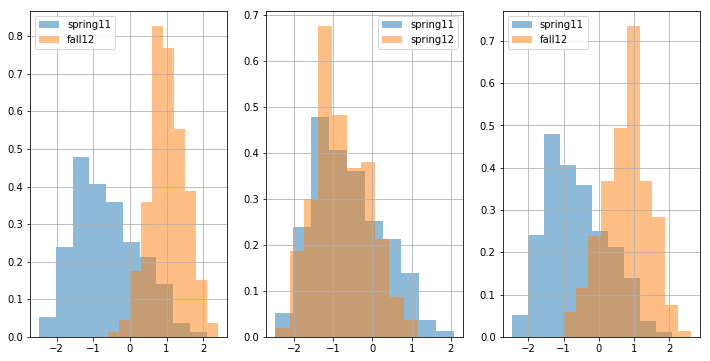

In [263]:
plt.figure(figsize = (12,6))
plt.subplot(1,3,1)
spring_11['temp'].hist(alpha = 0.5, label = 'spring11', density=True)
fall_11['temp'].hist(alpha = 0.5, label = 'fall12', density = True)
plt.legend()

plt.subplot(1,3,2)
spring_11['temp'].hist(alpha = 0.5, label = 'spring11', density = True)
spring_12['temp'].hist(alpha = 0.5, label = 'spring12', density = True)
plt.legend()

plt.subplot(1,3,3)
spring_11['temp'].hist(alpha = 0.5, label = 'spring11', density = True)
fall_12['temp'].hist(alpha = 0.5, label = 'fall12', density = True)
plt.legend()

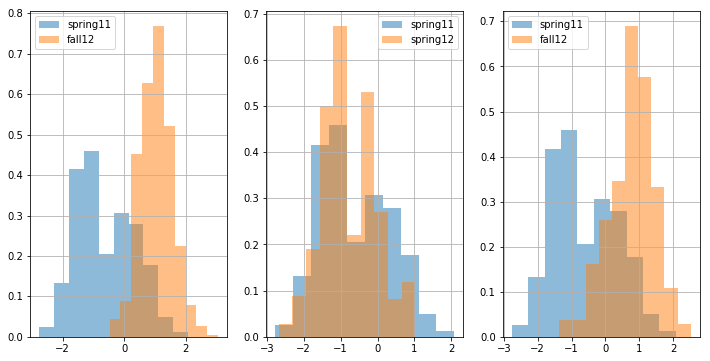

In [266]:
plt.figure(figsize = (12,6))
plt.subplot(1,3,1)
spring_11['atemp'].hist(alpha = 0.5, label = 'spring11', density = True)
fall_11['atemp'].hist(alpha = 0.5, label = 'fall12', density = True)
plt.legend()

plt.subplot(1,3,2)
spring_11['atemp'].hist(alpha = 0.5, label = 'spring11', density = True)
spring_12['atemp'].hist(alpha = 0.5, label = 'spring12', density = True)
plt.legend()

plt.subplot(1,3,3)
spring_11['atemp'].hist(alpha = 0.5, label = 'spring11', density = True)
fall_12['atemp'].hist(alpha = 0.5, label = 'fall12', density = True)
plt.legend()

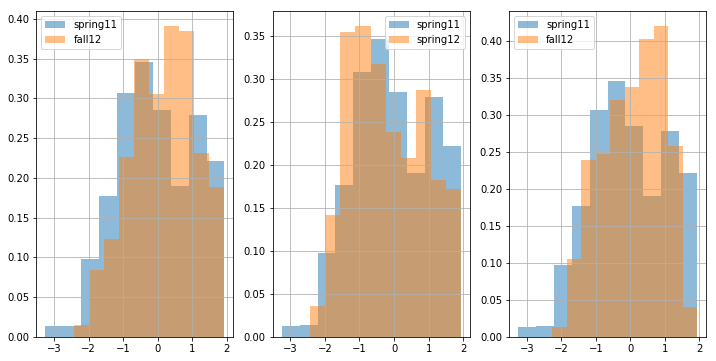

In [268]:
plt.figure(figsize = (12,6))
plt.subplot(1,3,1)
spring_11['hum'].hist(alpha = 0.5, label = 'spring11', density = True)
fall_11['hum'].hist(alpha = 0.5, label = 'fall12', density = True)
plt.legend()

plt.subplot(1,3,2)
spring_11['hum'].hist(alpha = 0.5, label = 'spring11', density = True)
spring_12['hum'].hist(alpha = 0.5, label = 'spring12', density = True)
plt.legend()

plt.subplot(1,3,3)
spring_11['hum'].hist(alpha = 0.5, label = 'spring11', density = True)
fall_12['hum'].hist(alpha = 0.5, label = 'fall12', density = True)
plt.legend()

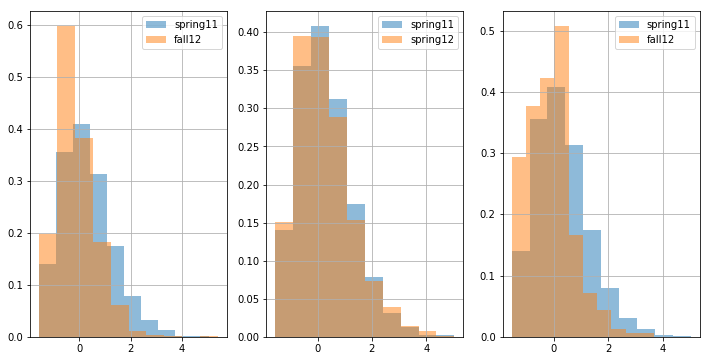

In [270]:
plt.figure(figsize = (12,6))
plt.subplot(1,3,1)
spring_11['windspeed'].hist(alpha = 0.5, label = 'spring11', density = True)
fall_11['windspeed'].hist(alpha = 0.5, label = 'fall12', density = True)
plt.legend()

plt.subplot(1,3,2)
spring_11['windspeed'].hist(alpha = 0.5, label = 'spring11', density = True)
spring_12['windspeed'].hist(alpha = 0.5, label = 'spring12', density =True)
plt.legend()

plt.subplot(1,3,3)
spring_11['windspeed'].hist(alpha = 0.5, label = 'spring11', density= True)
fall_12['windspeed'].hist(alpha = 0.5, label = 'fall12', density = True)
plt.legend()

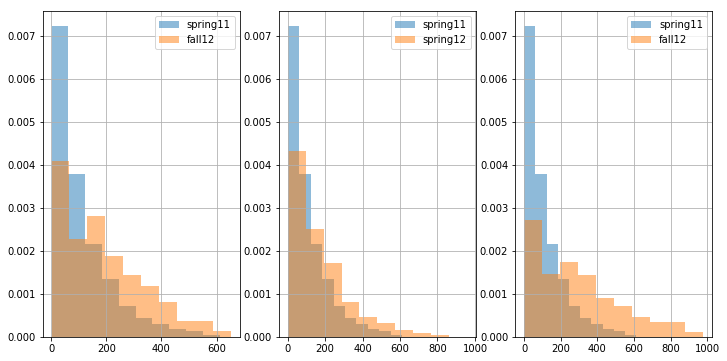

In [271]:
plt.figure(figsize = (12,6))
plt.subplot(1,3,1)
spring_11['cnt'].hist(alpha = 0.5, label = 'spring11', density = True)
fall_11['cnt'].hist(alpha = 0.5, label = 'fall12', density = True)
plt.legend()

plt.subplot(1,3,2)
spring_11['cnt'].hist(alpha = 0.5, label = 'spring11', density = True)
spring_12['cnt'].hist(alpha = 0.5, label = 'spring12', density = True)
plt.legend()

plt.subplot(1,3,3)
spring_11['cnt'].hist(alpha = 0.5, label = 'spring11', density = True)
fall_12['cnt'].hist(alpha = 0.5, label = 'fall12', density = True)
plt.legend()

# 学習 by XGboost

In [162]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

## 重みなしの学習(num_round =20)

In [336]:
num_core = 2
dtrain = xgb.DMatrix(
    spring_11[['temp', 'atemp', 'hum', 'windspeed']], spring_11['cnt'])
dtest1 = xgb.DMatrix(fall_11[['temp', 'atemp', 'hum', 'windspeed']], fall_11['cnt'])
dtest2 = xgb.DMatrix(spring_12[['temp', 'atemp', 'hum', 'windspeed']], spring_12['cnt'])
dtest3 = xgb.DMatrix(fall_12[['temp', 'atemp', 'hum', 'windspeed']], fall_12['cnt'])

watchlist = [(dtrain, 'train')]
param = {'max_depth': 6, 'eta': 0.2, 'lambda':1,
         'silent': 0, 'nthread': num_core,
         'objective': 'reg:linear', 'booster': 'gbtree'}
num_round = 20
non_weight = xgb.train(param, dtrain, num_round)

In [449]:
print('train error:', np.sqrt((non_weight.predict(dtrain) - dtrain.get_label())**2).mean())
print('test_1 error:', np.sqrt((non_weight.predict(dtest1) - dtest1.get_label())**2).mean())
print('test_2 error:', np.sqrt((non_weight.predict(dtest2) - dtest2.get_label())**2).mean())
print('test_3 error:', np.sqrt((non_weight.predict(dtest3) - dtest3.get_label())**2).mean())

train error: 51.610783
test_1 error: 119.87656
test_2 error: 106.72612
test_3 error: 168.12204


## 重みなしの学習(num_round =100)

In [320]:
num_core = 2
dtrain = xgb.DMatrix(
    spring_11[['temp', 'atemp', 'hum', 'windspeed']], spring_11['cnt'])
dtest1 = xgb.DMatrix(fall_11[['temp', 'atemp', 'hum', 'windspeed']], fall_11['cnt'])
dtest2 = xgb.DMatrix(spring_12[['temp', 'atemp', 'hum', 'windspeed']], spring_12['cnt'])
dtest3 = xgb.DMatrix(fall_12[['temp', 'atemp', 'hum', 'windspeed']], fall_12['cnt'])

watchlist = [(dtrain, 'train')]
param = {'max_depth': 6, 'eta': 0.2, 'lambda':1,
         'silent': 0, 'nthread': num_core,
         'objective': 'reg:linear', 'booster': 'gbtree'}
num_round = 100
non_weight = xgb.train(param, dtrain, num_round)

In [321]:
print('train error:', np.sqrt((non_weight.predict(dtrain) - dtrain.get_label())**2).mean())
print('test_1 error:', np.sqrt((non_weight.predict(dtest1) - dtest1.get_label())**2).mean())
print('test_2 error:', np.sqrt((non_weight.predict(dtest2) - dtest2.get_label())**2).mean())
print('test_3 error:', np.sqrt((non_weight.predict(dtest3) - dtest3.get_label())**2).mean())

train error: 41.659313
test_1 error: 126.99444
test_2 error: 107.917366
test_3 error: 172.08653


## 重みなしの学習(num_round =300)

In [324]:
num_core = 2
dtrain = xgb.DMatrix(
    spring_11[['temp', 'atemp', 'hum', 'windspeed']], spring_11['cnt'])
dtest1 = xgb.DMatrix(fall_11[['temp', 'atemp', 'hum', 'windspeed']], fall_11['cnt'])
dtest2 = xgb.DMatrix(spring_12[['temp', 'atemp', 'hum', 'windspeed']], spring_12['cnt'])
dtest3 = xgb.DMatrix(fall_12[['temp', 'atemp', 'hum', 'windspeed']], fall_12['cnt'])

watchlist = [(dtrain, 'train')]
param = {'max_depth': 6, 'eta': 0.2, 'lambda':1,
         'silent': 0, 'nthread': num_core,
         'objective': 'reg:linear', 'booster': 'gbtree'}
num_round = 300
non_weight = xgb.train(param, dtrain, num_round)

In [325]:
print('train error:', np.sqrt((non_weight.predict(dtrain) - dtrain.get_label())**2).mean())
print('test_1 error:', np.sqrt((non_weight.predict(dtest1) - dtest1.get_label())**2).mean())
print('test_2 error:', np.sqrt((non_weight.predict(dtest2) - dtest2.get_label())**2).mean())
print('test_3 error:', np.sqrt((non_weight.predict(dtest3) - dtest3.get_label())**2).mean())

train error: 30.661442
test_1 error: 132.55879
test_2 error: 111.60272
test_3 error: 176.33792


## Ru_LSIFによる重み付け(num_round = 300)

### $\alpha$をチューニングしないと精度はかえって落ちる結果に
- 原論文でも言われているように、$\alpha = 0$だと精度が落ちてしまう

In [205]:
from pyRULSIF import *
from pylab import *

In [316]:
data_list = []
data_list_weight = []
for hoge in [fall_11, spring_12, fall_12]:
    x_de = np.array(spring_11[['temp', 'atemp', 'hum', 'windspeed']]).T
    x_nu = np.array(hoge[['temp', 'atemp', 'hum', 'windspeed']]).T
    x_re = np.tile(np.linspace(-6,6, 1000)[:,np.newaxis], 4).T

    alpha_list = [0, 0.2, 0.4, 0.5, 0.6]
    models_lsif = []
    weight_list = []
    for i in alpha_list:
        alpha = i
        PE, w, s = R_ULSIF(x_nu, x_de, c_[x_re, x_nu, x_de], alpha,
                           sigma_list(x_nu, x_de), lambda_list(), x_nu.shape[1], 5)

        dtrain = xgb.DMatrix(
            spring_11[['temp', 'atemp', 'hum', 'windspeed']], spring_11['cnt'], weight=w[-x_de.shape[1]:])
        
        ru_lsif = xgb.train(param, dtrain, num_round)
        models_lsif.append(ru_lsif)
        weight_list.append(w)
    data_list.append(models_lsif)
    data_list_weight.append(weight)

### trainの結果

In [347]:
train = xgb.DMatrix(spring_11[['temp', 'atemp', 'hum', 'windspeed']], spring_11['cnt'])
print([np.sqrt((data_list[0][x].predict(train) - train.get_label())**2).mean() for x in range(len(alpha_list))])
print([np.sqrt((data_list[1][x].predict(train) - train.get_label())**2).mean() for x in range(len(alpha_list))])
print([np.sqrt((data_list[2][x].predict(train) - train.get_label())**2).mean() for x in range(len(alpha_list))])

[49.879467, 48.85316, 47.9121, 48.667072, 47.38147]
[35.81224, 35.24069, 34.908092, 34.720814, 33.927505]
[43.167137, 40.661045, 39.496185, 38.512966, 37.555496]


### test(fall_11) result

In [346]:
test = xgb.DMatrix(fall_11[['temp', 'atemp', 'hum', 'windspeed']], fall_11['cnt'])
print([np.sqrt((data_list[0][x].predict(test) - test.get_label())**2).mean() for x in range(len(alpha_list))])


[134.04553, 132.40523, 131.88261, 132.78401, 133.69115]


### test(spring_12) result

In [345]:
test = xgb.DMatrix(spring_12[['temp', 'atemp', 'hum', 'windspeed']], spring_12['cnt'])
print([np.sqrt((data_list[1][x].predict(test) - test.get_label())**2).mean() for x in range(len(alpha_list))])

[112.06149, 111.814224, 111.209015, 111.39806, 111.5267]


### test(fall_12) result

In [344]:
test = xgb.DMatrix(fall_12[['temp', 'atemp', 'hum', 'windspeed']], fall_12['cnt'])
print([np.sqrt((data_list[2][x].predict(test) - test.get_label())**2).mean() for x in range(len(alpha_list))])

[179.37566, 177.65587, 177.15778, 177.31723, 176.083]


## Ru_LSIFによる重み付け(num_round = 20)

In [451]:
lsif_20 = []
lsif_20_weight = []
param = {'max_depth': 6, 'eta': 0.2, 'lambda':1,
         'silent': 0, 'nthread': num_core,
         'objective': 'reg:linear', 'booster': 'gbtree'}
num_round = 20
for hoge in [fall_11, spring_12, fall_12]:
    x_de = np.array(spring_11[['temp', 'atemp', 'hum', 'windspeed']]).T
    x_nu = np.array(hoge[['temp', 'atemp', 'hum', 'windspeed']]).T
    x_re = np.tile(np.linspace(-6,6, 1000)[:,np.newaxis], 4).T

    alpha_list = [0, 0.2, 0.4, 0.5, 0.6]
    models_lsif = []
    weight_list = []
    for i in alpha_list:
        alpha = i
        PE, w, s = R_ULSIF(x_nu, x_de, c_[x_re, x_nu, x_de], alpha,
                           sigma_list(x_nu, x_de), lambda_list(), x_nu.shape[1], 5)

        dtrain = xgb.DMatrix(
            spring_11[['temp', 'atemp', 'hum', 'windspeed']], spring_11['cnt'], weight=w[-x_de.shape[1]:])
        
        ru_lsif = xgb.train(param, dtrain, num_round)
        models_lsif.append(ru_lsif)
        weight_list.append(w)
    lsif_20.append(models_lsif)
    lsif_20_weight.append(weight)

### trainの結果

In [452]:
train = xgb.DMatrix(spring_11[['temp', 'atemp', 'hum', 'windspeed']], spring_11['cnt'])
print([np.sqrt((lsif_20[0][x].predict(train) - train.get_label())**2).mean() for x in range(len(alpha_list))])
print([np.sqrt((lsif_20[1][x].predict(train) - train.get_label())**2).mean() for x in range(len(alpha_list))])
print([np.sqrt((lsif_20[2][x].predict(train) - train.get_label())**2).mean() for x in range(len(alpha_list))])

[59.20735, 57.19169, 56.633713, 56.6989, 56.223602]
[52.926186, 52.691475, 52.3796, 52.152763, 52.05333]
[55.656223, 56.73158, 56.557686, 57.93762, 57.08303]


### test(fall_11) result

In [453]:
test = xgb.DMatrix(fall_11[['temp', 'atemp', 'hum', 'windspeed']], fall_11['cnt'])
print([np.sqrt((lsif_20[0][x].predict(test) - test.get_label())**2).mean() for x in range(len(alpha_list))])


[121.88352, 120.26528, 119.26676, 119.88367, 119.93422]


### test(spring_12) result

In [454]:
test = xgb.DMatrix(spring_12[['temp', 'atemp', 'hum', 'windspeed']], spring_12['cnt'])
print([np.sqrt((lsif_20[1][x].predict(test) - test.get_label())**2).mean() for x in range(len(alpha_list))])

[106.68394, 106.70871, 106.93612, 106.910576, 107.04261]


### test(fall_12) result

In [455]:
test = xgb.DMatrix(fall_12[['temp', 'atemp', 'hum', 'windspeed']], fall_12['cnt'])
print([np.sqrt((lsif_20[2][x].predict(test) - test.get_label())**2).mean() for x in range(len(alpha_list))])

[170.92145, 168.35794, 167.92525, 167.88222, 167.48935]


## MCEWによる重み付け(num_round = 300)

In [399]:
def cal_MCEW(train, test):
    # train, test ndarray object number of data(row) × n-dim(column)
    grad = np.log(distance.cdist(train,test).sum(axis = 1))
    if sum(np.isinf(grad)) > 0:
        grad[np.isinf(grad)] = 0
    grad = grad/grad.sum()
    weight = 1 - 1 / grad.max() * grad
    return(weight / weight.sum())

In [443]:
mcew_300 = []
weight_list = []
param = {'max_depth': 6, 'eta': 0.2, 'lambda':1,
         'silent': 0, 'nthread': num_core,
         'objective': 'reg:linear', 'booster': 'gbtree'}
num_round = 300
for hoge in [fall_11, spring_12, fall_12]:
    x_de = np.array(spring_11[['temp', 'atemp', 'hum', 'windspeed']])
    x_nu = np.array(hoge[['temp', 'atemp', 'hum', 'windspeed']])
    
    w = cal_MCEW(x_de*100, x_nu*100)
    dtrain = xgb.DMatrix(
        spring_11[['temp', 'atemp', 'hum', 'windspeed']], spring_11['cnt'], weight=w*len(w))
    
    mcew = xgb.train(param, dtrain, num_round)
    
    mcew_300.append(mcew)
    weight_list.append(w)

### test(spring_11) result(train error)

In [444]:
train = xgb.DMatrix(spring_11[['temp', 'atemp', 'hum', 'windspeed']], spring_11['cnt'])
print([np.sqrt((mcew_300[x].predict(train) - train.get_label())**2).mean() for x in range(3)])

[30.415356, 31.290129, 30.446854]


### test(fall_11) result

In [445]:
train = xgb.DMatrix(fall_11[['temp', 'atemp', 'hum', 'windspeed']], fall_11['cnt'])
print(np.sqrt((mcew_300[0].predict(train) - train.get_label())**2).mean())

134.27448


### test(spring_12) result

In [446]:
train = xgb.DMatrix(spring_12[['temp', 'atemp', 'hum', 'windspeed']], spring_12['cnt'])
print(np.sqrt((mcew_300[1].predict(train) - train.get_label())**2).mean() )

111.823845


### test(fall_12) result

In [447]:
train = xgb.DMatrix(fall_12[['temp', 'atemp', 'hum', 'windspeed']], fall_12['cnt'])
print(np.sqrt((mcew_300[2].predict(train) - train.get_label())**2).mean())

179.62065


## MCEW(num_round = 20)

In [438]:
mcew_20 = []
weight_list_20 = []
param = {'max_depth': 6, 'eta': 0.2, 'lambda':1,
         'silent': 0, 'nthread': num_core,
         'objective': 'reg:linear', 'booster': 'gbtree'}
num_round = 20
for hoge in [fall_11, spring_12, fall_12]:
    x_de = np.array(spring_11[['temp', 'atemp', 'hum', 'windspeed']])
    x_nu = np.array(hoge[['temp', 'atemp', 'hum', 'windspeed']])
    
    w = cal_MCEW(x_de*100, x_nu*100)
    dtrain = xgb.DMatrix(
        spring_11[['temp', 'atemp', 'hum', 'windspeed']], spring_11['cnt'], weight=w*len(w))
    
    mcew = xgb.train(param, dtrain, num_round)
    
    mcew_20.append(mcew)
    weight_list.append(w)

### test(spring_11) result(train error)

In [439]:
train = xgb.DMatrix(spring_11[['temp', 'atemp', 'hum', 'windspeed']], spring_11['cnt'])
print([np.sqrt((mcew_20[x].predict(train) - train.get_label())**2).mean() for x in range(3)])

[51.402054, 51.798107, 51.767956]


### test(fall_11) result

In [440]:
train = xgb.DMatrix(fall_11[['temp', 'atemp', 'hum', 'windspeed']], fall_11['cnt'])
print(np.sqrt((mcew_20[0].predict(train) - train.get_label())**2).mean())

119.164116


### test(spring_12) result

In [441]:
train = xgb.DMatrix(spring_12[['temp', 'atemp', 'hum', 'windspeed']], spring_12['cnt'])
print(np.sqrt((mcew_20[1].predict(train) - train.get_label())**2).mean() )

106.418594


### test(fall_12) result

In [442]:
train = xgb.DMatrix(fall_12[['temp', 'atemp', 'hum', 'windspeed']], fall_12['cnt'])
print(np.sqrt((mcew_20[2].predict(train) - train.get_label())**2).mean())

168.55003
